# OpenDrive 协议

代码库：OpenDrive

## 基本概念

- xodr：基于xml的一种数据结构，OpenDrive格式，格式的具体形式需要大家仔细阅读spec，给个示例展示下

<img src="./opendrive_format_sample.png" width = "500" div align=center />


## 依赖库说明

- matplotlib, numpy

- lxml：解析xml的python工具库

- opendriveparser：opendrive解析库，将xodr转化为python数据结构，目前没有完全完成，有一部分并没有解析，感兴趣的同学可以补充完善


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import math
from lxml import etree
from opendriveparser import parse_opendrive

In [44]:
f = open("./Crossing8Course.xodr", 'r')
openDrive = parse_opendrive(etree.parse(f).getroot())
f.close()

In [45]:
precision = 0.5

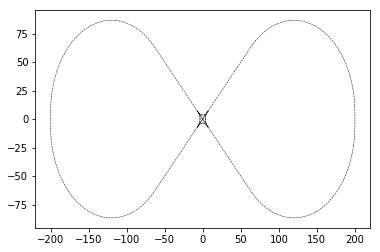

In [46]:
for road in openDrive.roads:  
    # 绘制每一条Road
    ref_pos_x = []
    ref_pos_y = []
    ref_heading = []
    
    plan_view = road.planView
    length = plan_view.getLength()

    numSteps = max(2, np.ceil(length / float(precision)))
    for s in np.linspace(0, length, int(numSteps)):
        pos, tangent = plan_view.calc(s)  # 最重要的一步：获取Reference line的世界坐标和角度

        ref_pos_x.append(pos[0])
        ref_pos_y.append(pos[1])
        ref_heading.append(tangent)

    plt.plot(ref_pos_x, ref_pos_y, 'k--', linewidth=0.5)


plt.show()

### 如何绘制参考线

- 回到文档里看说明！p19

    - Line：没有曲率

    - Spiral：也称为欧拉螺旋线，曲率是线型变化的

    - Arc：弧线，常量非0的曲率
    
    - Cubic polynom：立方多项式，曲率不确定
    
- 本质上是一种坐标变换，从车道坐标系变换为世界坐标系

<img src="./lane_geo.png" width = "500" div align=center />


In [ ]:
class Line(Geometry):

    def __init__(self, startPosition, heading, length):
        self.startPosition = np.array(startPosition)
        self.heading = heading
        self.length = length

    def getStartPosition(self):
        return self.startPosition

    def getLength(self):
        return self.length

    def calcPosition(self, s):
        pos = self.startPosition + np.array([s * np.cos(self.heading), s * np.sin(self.heading)])
        tangent = self.heading

        return (pos, tangent)

$$
\left\{\begin{matrix}
x=s\cos\theta \\ 
y=s\sin\theta
\end{matrix}\right.
$$

In [ ]:
class Arc(Geometry):

    def __init__(self, startPosition, heading, length, curvature):
        self.startPosition = np.array(startPosition)
        self.heading = heading
        self.length = length
        self.curvature = curvature

    def getStartPosition(self):
        return self.startPosition

    def getLength(self):
        return self.length

    def calcPosition(self, s):
        c = self.curvature
        hdg = self.heading - np.pi / 2

        a = 2 / c * np.sin(s * c / 2)
        alpha = (np.pi - s * c) / 2 - hdg

        dx = -1 * a * np.cos(alpha)
        dy = a * np.sin(alpha)

        pos = self.startPosition + np.array([dx, dy])
        tangent = self.heading + s * self.curvature

        return (pos, tangent)

- 计算出圆心角和半径
    - 圆的半径是曲率的倒数，$r=\frac{1}{c}$
    - s为弧长，$s=2\pi r\theta$

- 三角公式计算出新的坐标点位置

- 车道线角度：
$$
{h}'=h+sc
$$

In [ ]:
class Spiral(Geometry):

    def __init__(self, startPosition, heading, length, curvStart, curvEnd):
        self._startPosition = np.array(startPosition)
        self._heading = heading
        self._length = length
        self._curvStart = curvStart
        self._curvEnd = curvEnd

        self._spiral = EulerSpiral.createFromLengthAndCurvature(self._length, self._curvStart, self._curvEnd)

    def getStartPosition(self):
        return self._startPosition

    def getLength(self):
        return self._length

    def calcPosition(self, s):
        (x, y, t) = self._spiral.calc(s, self._startPosition[0], self._startPosition[1], self._curvStart, self._heading)

        return (np.array([x, y]), t)

In [ ]:
class EulerSpiral(object):

    def __init__(self, gamma):
        self._gamma = gamma

    @staticmethod
    def createFromLengthAndCurvature(length, curvStart, curvEnd):
        return EulerSpiral(1 * (curvEnd - curvStart) / length)

    def calc(self, s, x0=0, y0=0, kappa0=0, theta0=0):

        # Start
        C0 = x0 + 1j * y0

        if self._gamma == 0 and kappa0 == 0:
            # Straight line
            Cs = C0 + np.exp(1j * theta0 * s)

        elif self._gamma == 0 and kappa0 != 0:
            # Arc
            Cs = C0 + np.exp(1j * theta0) / kappa0 * (np.sin(kappa0 * s) + 1j * (1 - np.cos(kappa0 * s)))

        else:
            # Fresnel integrals
            Sa, Ca = fresnel((kappa0 + self._gamma * s) / np.sqrt(np.pi * np.abs(self._gamma)))
            Sb, Cb = fresnel(kappa0 / np.sqrt(np.pi * np.abs(self._gamma)))

            # Euler Spiral
            Cs1 = np.sqrt(np.pi / np.abs(self._gamma)) * np.exp(1j * (theta0 - kappa0**2 / 2 / self._gamma))
            Cs2 = np.sign(self._gamma) * (Ca - Cb) + 1j * Sa - 1j * Sb

            Cs = C0 + Cs1 * Cs2

        # Tangent at each point
        theta = self._gamma * s**2 / 2 + kappa0 * s + theta0

        return (Cs.real, Cs.imag, theta)

计算非常复杂，计算图形学里已经有给出的合理公式，可供参考：

- https://en.wikipedia.org/wiki/Euler_spiral

- http://www.opendrive.org/tools/odrSpiral.zip : 官方提供了C实现

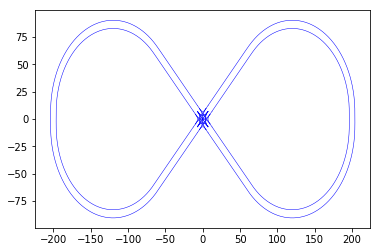

In [47]:
for road in openDrive.roads:
    # 绘制左右车道
    left_lane = []
    right_lane = []
    for lane_section in road.lanes.laneSections:
        for llane in lane_section.leftLanes:
            if llane.type == "driving":
                left_lane.append(llane)
                break
        for rlane in lane_section.rightLanes:
            if rlane.type == "driving":
                right_lane.append(rlane)
                break

    left_pos_x = []
    left_pos_y = []
    right_pos_x = []
    right_pos_y = []
    
    plan_view = road.planView
    length = plan_view.getLength()

    numSteps = max(2, np.ceil(length / float(precision)))
    for s in np.linspace(0, length, int(numSteps)):
        pos, tangent = plan_view.calc(s)

        # 计算左车道线宽
        distance = 0
        for llane in left_lane:
            for width in llane.widths:
                # 多项式计算方法, p55
                distance = np.polynomial.polynomial.polyval(s - width.sOffset, width.coeffs)

        ortho = tangent + np.pi / 2
        new_pos = pos + np.array([distance * np.cos(ortho), distance * np.sin(ortho)])
        left_pos_x.append(new_pos[0])
        left_pos_y.append(new_pos[1])
        
        # 计算右车道线宽
        distance = 0
        for rlane in right_lane:
            for width in rlane.widths:
                distance = np.polynomial.polynomial.polyval(s - width.sOffset, width.coeffs)

        ortho = tangent - np.pi / 2
        new_pos = pos + np.array([distance * np.cos(ortho), distance * np.sin(ortho)])
        right_pos_x.append(new_pos[0])
        right_pos_y.append(new_pos[1])

    plt.plot(right_pos_x, right_pos_y, 'b', linewidth=0.5)
    plt.plot(left_pos_x, left_pos_y, 'b', linewidth=0.5)

plt.show()

In [48]:
for road in openDrive.roads:
    print("Road ID: {}".format(road.id))

Road ID: 500
Road ID: 514
Road ID: 515
Road ID: 516
Road ID: 517
Road ID: 501
Road ID: 502
Road ID: 503
Road ID: 504
Road ID: 505
Road ID: 506
Road ID: 507
Road ID: 508
Road ID: 509
Road ID: 510
Road ID: 511
Road ID: 512
Road ID: 513


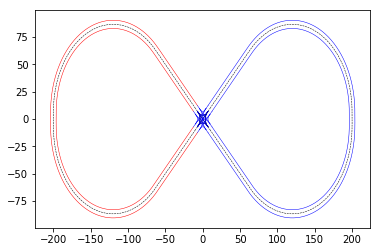

In [49]:
for road in openDrive.roads:  
    # 对每一条road进行绘制
    plan_view = road.planView
    length = plan_view.getLength()

    left_lane = []
    right_lane = []
    for lane_section in road.lanes.laneSections:
        for llane in lane_section.leftLanes:
            if llane.type == "driving":
                left_lane.append(llane)
                break
        for rlane in lane_section.rightLanes:
            if rlane.type == "driving":
                right_lane.append(rlane)
                break

    ref_pos_x = []
    ref_pos_y = []
    ref_heading = []
    left_pos_x = []
    left_pos_y = []
    right_pos_x = []
    right_pos_y = []

    numSteps = max(2, np.ceil(length / float(precision)))
    for s in np.linspace(0, length, int(numSteps)):
        pos, tangent = plan_view.calc(s)

        ref_pos_x.append(pos[0])
        ref_pos_y.append(pos[1])
        ref_heading.append(tangent)

        distance = 0
        for llane in left_lane:
            for width in llane.widths:
                distance = np.polynomial.polynomial.polyval(s - width.sOffset, width.coeffs)

        ortho = tangent + np.pi / 2
        new_pos = pos + np.array([distance * np.cos(ortho), distance * np.sin(ortho)])
        left_pos_x.append(new_pos[0])
        left_pos_y.append(new_pos[1])

        distance = 0
        for rlane in right_lane:
            for width in rlane.widths:
                distance = np.polynomial.polynomial.polyval(s - width.sOffset, width.coeffs)

        ortho = tangent - np.pi / 2
        new_pos = pos + np.array([distance * np.cos(ortho), distance * np.sin(ortho)])
        right_pos_x.append(new_pos[0])
        right_pos_y.append(new_pos[1])

    if road.id == 509:
        plt.plot(ref_pos_x, ref_pos_y, 'k--', linewidth=0.5)
        plt.plot(right_pos_x, right_pos_y, 'r', linewidth=0.5)
        plt.plot(left_pos_x, left_pos_y, 'r', linewidth=0.5)
    else:
        plt.plot(ref_pos_x, ref_pos_y, 'k--', linewidth=0.5)
        plt.plot(right_pos_x, right_pos_y, 'b', linewidth=0.5)
        plt.plot(left_pos_x, left_pos_y, 'b', linewidth=0.5)

plt.show()

## 更多高精地图格式

- LaneLet：
    - 定义一种更高效便捷的道路描述结构（论文：Bender, J. Ziegler and C. Stiller: Lanelets: Efficient Map Representation for Autonomous Driving, submitted to IEEE Intelligent Vehicles Symposium (IV), 2014.）
    - 每个x、y点都进行了存储，边界的位置和曲率也重新定义了
    - 利用图网络表述道路关系

<img src="./LaneLetRoad.png" width = "500" div align=center />

- Apollo OpenDrive：
    - 更为复杂的路网情况，针对L4级别自动驾驶进行优化，包含了更多道路类型，例如：分叉汇入区域，环岛区域
    - 提供路标更多详细信息，减少在线计算，比如：路口红绿灯的精确位置，提高检测和识别区域的效率
    
<img src="./ApolloHDMap.png" width = "500" div align=center />


# 点云匹配

## 依赖库说明

- OpenCV3：目前最常用也是用途最广的图像处理依赖库，熟悉基本操作，比如cv::Mat、imread
- Eigen：C++下最常用的矩阵计算库，类似于Matlab，对矩阵的描述和计算都非常方便，任何计算都是矩阵
- PCL：Point Cloud Library，点云计算库，方便对点云进行操作和可视化

### 安装方法

ROS已经安装好了的话，应该只需要安装PCL库即可

- Eigen库使用源码拷贝的方式或apt-get安装
- Opencv安装可以用ppi源来安装，也可以用源码编译安装
- 在Ubuntu下使用apt-get安装PCL

#### PCL 安装

http://pointclouds.org/downloads/linux.html

1. sudo add-apt-repository ppa:v-launchpad-jochen-sprickerhof-de/pcl
1. sudo apt-get update
1. sudo apt-get install libpcl-all 

## 使用说明

代码库：JointMapping

1. cmake .
1. make
1. ./joinMap
1. pcl_viewer ./map.pcd

## 基础概念

- 相机内参：描述了相机将外界物体如何成像为图片的内部参数（还有一个相机内部参数：畸变参数）
- 相机外参：描述了如何把点从世界坐标系转换到相机坐标系（之前，我们了解世界坐标系、车道坐标系，之后还会学习到相机坐标系、车辆坐标系）
- 像素坐标系：也叫图像坐标系，灰度图：0~255（8位），深度图：0~65535（16位），彩图：多通道（RGB，BGR，RGBA等等）

<img src="./img_coordinate.png" width = "200" div align=center />

### 刚体运动方式

刚体运动是个六自由度的运动，XYZ坐标平移，rpy旋转（roll, pitch, yaw）；相机运动就是一个刚体运动，其坐标系是个移动坐标系

#### 旋转矩阵

相机坐标系中的物体坐标$p_{c}$，而在世界坐标系下$p_{w}$，如何转换？假设用一个$T$来表示坐标系的转换：
$$
p_{c}=Tp_{w}
$$

- 旋转坐标：
    - 两组坐标系的旋转是由两组坐标基的内积空间决定的，我们定义为$R$
    $$
    {a}'=Ra
    $$
    
    $$
    R=\begin{bmatrix}
    e_{1}t_{1} & e_{1}t_{2} & e_{1}t_{3}\\ 
    e_{2}t_{1} & e_{2}t_{2} & e_{2}t_{3}\\ 
    e_{3}t_{1} & e_{3}t_{2} & e_{3}t_{3}
    \end{bmatrix}
    $$
    - 这里e和t时两个空间坐标系的基坐标
    - 旋转矩阵其实描述的就是相机的旋转
- 平移坐标：
    - 平移向量我们定义为$t$，因此坐标系之间的转换结合起来就可以表述为：
    $$
    {a}'=Ra+t
    $$

#### 齐次坐标系、变换矩阵

上述的线型表述形式虽然做到了坐标变换，但是这个形式非常不利于多次变换，无法做到矩阵计算，因此引入齐次坐标系：
$$
\begin{bmatrix}
{a}'\\ 
1
\end{bmatrix}=\begin{bmatrix}
R & t \\ 
0 & 1
\end{bmatrix}\begin{bmatrix}
a\\ 
1
\end{bmatrix}=T\begin{bmatrix}
a\\ 
1
\end{bmatrix}
$$
至此，这里的$T$就和我们说的坐标系变换的$T$是同一个了，也称为变换矩阵；而增加了一个维度的坐标系$\begin{bmatrix}
a\\ 
1
\end{bmatrix}$也简化成$b$，称为齐次坐标系

- 举个例子：坐标系两次变换$b=T_{1}T_{2}{b}'$

#### 欧拉角

- yaw：绕Z轴旋转
- pitch：绕Y轴旋转
- roll：绕X轴旋转

#### 四元数（Quaternion）

是一种扩展复数，用于解决紧凑性（不产生任何冗余）和奇异性（在空间任何情况下连续，比如经纬度在90维度时经度时有奇异的）的平衡，表述如下：
$$
\mathbf{q}=q_{0}+q_{1}i+q_{2}j+q_{3}k=\begin{bmatrix}
s & v
\end{bmatrix}
$$
- s表示实部；v表示虚部；因此也就有了实四元数和虚四元数的区分

- 直观理解：空间中所有旋转都可以用四元数来表示，对于i、j、k本身的几何意义可以理解为一种旋转，但不是简单的围绕XYZ轴旋转的，实部主要是用于消除奇异性

- 某旋转绕单位向量$n=\begin{bmatrix}
n_{x} & n_{y} & n_{z}
\end{bmatrix}^{T}$旋转$\theta$角度，其四元数表达式为：
$$
q=\begin{bmatrix}
cos\frac{\theta }{2} & n_{x}sin\frac{\theta }{2} & n_{y}sin\frac{\theta }{2} & n_{z}sin\frac{\theta }{2}
\end{bmatrix}^{T}
$$

- 旋转后的点${p}'$可以这样表示：
$$
{p}'=qpq^{-1}
$$

- 用旋转矩阵的表示是这样：
$$
{p}'=Rp
$$

- 因此旋转矩阵和四元数是可以相互转化的

上述这些基本概念，是机器人学的一个空间基础，后续我们的无人车规划课程中还会用到

### 相机模型

相机成像的原理时针孔相机模型：

<img src="./camera_model.png" width = "100" div align=center />

- $P$表示物理世界中的一个点；${P}'$表示成像模型中的位置；坐标分别是$XYZ$和${X}'{Y}'{Z}'$

- 相似三角形关系：
$$
\frac{Z}{f}=\frac{X}{{X}'}=\frac{Y}{{Y}'}
$$

$$
{X}'=f\frac{X}{Z}
$$

$$
{Y}'=f\frac{Y}{Z}
$$

### 什么是相机内参？

我们还需要将成像坐标${P}'$还需要切换到像素坐标系中，要进行两步转换：缩放和原点平移

- 假设${P}'$的像素坐标为$\begin{bmatrix}
u & v
\end{bmatrix}^{T}$，变换坐标就是：

$$
\left\{\begin{matrix}
u=\alpha {X}'+{c}_x\\ 
v=\beta {X}'+{c}_y
\end{matrix}\right.
$$

$$
\left\{\begin{matrix}
u={f}_x\frac{X}{Z}+{c}_x\\ 
v={f}_y\frac{Y}{Z}+{c}_y
\end{matrix}\right.
$$

- 把这个形式切换到齐次坐标系：

$$
\begin{pmatrix}
u\\ 
v\\ 
1
\end{pmatrix}=\frac{1}{Z}\begin{pmatrix}
f_{x} & 0 & c_{x} \\ 
0 & f_{y} & c_{y} \\ 
0 & 0 & 1
\end{pmatrix}\begin{pmatrix}
X\\ 
Y\\ 
Z
\end{pmatrix}=\frac{1}{Z}KP$$

- 这里这个K就是我们说的内参矩阵，也是每个相机需要校准的内参

### 什么是相机外参？

我们注意一下，这里$P$是相机坐标系下的位置，而其世界坐标系下的坐标${P}_w$，可以根据旋转平移来得到：

$$
Z{P}_{uv}=K(R{P_w}+t)=KT{P}_w
$$

- 这里有齐次变换到非齐次坐标的变换

- 因此，相机姿态$R,t$又称为相机外参

- 外参会随着车辆移动而移动，因此我们高精地图构建过程中就是需要去估计这个外参，同时也是车辆的移动轨迹

### 数据结构

- PGM数据格式：Portable Gray Map，最简单的灰度图数据格式，这里我们拿来表示把点云压成平面的深度信息（0~65535），其中0表示没有检测到深度

- png：众所周知，RGB信息的常用格式

- pose：5组7状态，txt文档，$\begin{bmatrix}
x & y& z &{q}_x  & {q}_y & {q}_z & {q}_w
\end{bmatrix}$，平移向量和旋转四元数

- 简单看一下我们的数据是什么样子

## 代码实例

我们要完成如何两个事：

- 根据相机内参计算RGB和点云的对应关系

- 根据各图相机外参把点云和RGB融合进行图片融合，构成全局地图

### include

In [ ]:
#include <iostream>
#include <fstream>
using namespace std;
#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <Eigen/Geometry> 
#include <boost/format.hpp>  // for formating strings
#include <pcl/point_types.h> 
#include <pcl/io/pcd_io.h> 
#include <pcl/visualization/pcl_visualizer.h>

### main.cpp

In [ ]:
int main( int argc, char** argv )
{
    vector<cv::Mat> colorImgs, depthImgs; // 彩色图和深度图
    // typedef Transform< double, 3, Isometry > Eigen::Isometry3d -> 欧氏变换矩阵 : 虽然称为3d，实质上是4＊4的
    vector<Eigen::Isometry3d, Eigen::aligned_allocator<Eigen::Isometry3d>> poses; // 相机位姿
    
    ifstream fin("./pose/pose.txt");
    if (!fin)
    {
        cerr<<"请在有./pose/pose.txt的目录下运行此程序"<<endl;
        return 1;
    }
    
    for ( int i=0; i<5; i++ )
    {
        boost::format fmt( "./%s/%d.%s" ); //图像文件格式
        colorImgs.push_back( cv::imread( (fmt%"color"%(i+1)%"png").str() ));
        depthImgs.push_back( cv::imread( (fmt%"depth"%(i+1)%"pgm").str(), -1 )); // -1 : Read raw data img
        
        double data[7] = {0};
        for ( auto& d:data ) {
            fin>>d;
        }
        Eigen::Quaterniond q( data[6], data[3], data[4], data[5] ); // 四元数
        Eigen::Isometry3d T(q); // Initial T
        T.pretranslate( Eigen::Vector3d( data[0], data[1], data[2] ));
        poses.push_back( T );
    }
    
    // 计算点云并拼接
    // 相机内参 
    double cx = 325.5;
    double cy = 253.5;
    double fx = 518.0;
    double fy = 519.0;
    double depthScale = 1000.0;
    
    cout<<"正在将图像转换为点云..."<<endl;
    
    // 定义点云使用的格式：这里用的是XYZRGB
    typedef pcl::PointXYZRGB PointT; 
    typedef pcl::PointCloud<PointT> PointCloud;
    
    // 新建一个点云
    PointCloud::Ptr pointCloud( new PointCloud ); 
    for ( int i=0; i<5; i++ )
    {
        cout<<"转换图像中: "<<i+1<<endl; 
        cv::Mat color = colorImgs[i]; 
        cv::Mat depth = depthImgs[i];
        Eigen::Isometry3d T = poses[i];
        for ( int v=0; v<color.rows; v++ )
            for ( int u=0; u<color.cols; u++ )
            {
                unsigned int d = depth.ptr<unsigned short> ( v )[u]; // 深度值
                if ( d==0 ) continue; // 为0表示没有测量到
                Eigen::Vector3d point; 
                point[2] = double(d)/depthScale; // Unit conversion
                point[0] = (u-cx)*point[2]/fx;
                point[1] = (v-cy)*point[2]/fy; 
                Eigen::Vector3d pointWorld = T*point;
                
                PointT p ;
                p.x = pointWorld[0];
                p.y = pointWorld[1];
                p.z = pointWorld[2];
                p.b = color.data[ v*color.step+u*color.channels() ];
                p.g = color.data[ v*color.step+u*color.channels()+1 ];
                p.r = color.data[ v*color.step+u*color.channels()+2 ];
                pointCloud->points.push_back( p );
            }
    }
    
    pointCloud->is_dense = false;
    cout<<"点云共有"<<pointCloud->size()<<"个点."<<endl;
    pcl::io::savePCDFileBinary("map.pcd", *pointCloud );
    return 0;
}

### 思考

- 像素坐标${P}_c$到像素坐标的关系根据公式有：
$$
d\begin{bmatrix}
u\\ 
v\\ 
1
\end{bmatrix}=K{P}_c
$$
- 那么世界坐标系$x,y,z$是什么？

$$
z=d
$$

$$
x=\frac{u-{c}_x}{{f}_x}z
$$

$$
y=\frac{v-{c}_y}{{f}_y}z
$$

- 外参怎么拿？外参就是通过运动学估计滤波以及定位辅助（IMU，RTK）进行校正

- 如何标定内参？N角点K棋盘标定法，对比世界坐标系和像素坐标系的位置就可以根据公式进行反求


### CMakeLists

In [ ]:
cmake_minimum_required( VERSION 2.8 )
project( joinMap )

set( CMAKE_BUILD_TYPE Release )
# C++11 标准 && O0~O3 优化方式，推荐O2，O3
set( CMAKE_CXX_FLAGS "-std=c++11 -O3" )

# opencv 
find_package( OpenCV REQUIRED )
include_directories( ${OpenCV_INCLUDE_DIRS} )

# eigen 
include_directories( "/usr/include/eigen3/" )

# pcl 
find_package( PCL REQUIRED COMPONENT common io )
include_directories( ${PCL_INCLUDE_DIRS} )
add_definitions( ${PCL_DEFINITIONS} )

add_executable( joinMap joinMap.cpp ) # file_name
target_link_libraries( joinMap ${OpenCV_LIBS} ${PCL_LIBRARIES} )

### 运行pcl查看点云图

In [ ]:
pcl_viewer map.pcd 
// for mac :
// cd /usr/local/Cellar/pcl/1.9.1_1/pcl_viewer.app/Contents/MacOS/
// pcl_viewer ~/Desktop/map.pcd

## OpenCV 练习

代码库：opencv

OpenCV代码安装很简单，如果ROS Kinetic已经安装好的话，默认应该是OpenCV3版本

- 如果你们用的是OpenCV2.4也可以，注意修改个别的API即可
- OpenCV3单独安装也很简单：sudo apt-get install libopencv-dev python3-opencv
- 如果感兴趣的，可以自行从源码安装一次：https://github.com/opencv/opencv

### Cpp代码

In [ ]:
#include <iostream>
#include <chrono>
using namespace std;

#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>

int main ( int argc, char** argv )
{
    // 读取argv[1]指定的图像
    cv::Mat image;
    image = cv::imread ( argv[1] ); //cv::imread函数读取指定路径下的图像
    // 判断图像文件是否正确读取
    if ( image.data == nullptr ) //数据不存在,可能是文件不存在
    {
        cerr<<"文件"<<argv[1]<<"不存在."<<endl;
        return 0;
    }
    
    // 文件顺利读取, 首先输出一些基本信息
    cout<<"图像宽为"<<image.cols<<",高为"<<image.rows<<",通道数为"<<image.channels()<<endl;
    cv::imshow ( "image", image );      // 用cv::imshow显示图像
    cv::waitKey ( 0 );                  // 暂停程序,等待一个按键输入
    // 判断image的类型
    if ( image.type() != CV_8UC1 && image.type() != CV_8UC3 )
    {
        // 图像类型不符合要求
        cout<<"请输入一张彩色图或灰度图."<<endl;
        return 0;
    }

    // 遍历图像, 请注意以下遍历方式亦可使用于随机像素访问
    // 使用 std::chrono 来给算法计时
    chrono::steady_clock::time_point t1 = chrono::steady_clock::now();
    for ( size_t y=0; y<image.rows; y++ )
    {
        // 用cv::Mat::ptr获得图像的行指针
        unsigned char* row_ptr = image.ptr<unsigned char> ( y );  // row_ptr是第y行的头指针
        for ( size_t x=0; x<image.cols; x++ )
        {
            // 访问位于 x,y 处的像素
            unsigned char* data_ptr = &row_ptr[ x*image.channels() ]; // data_ptr 指向待访问的像素数据
            // 输出该像素的每个通道,如果是灰度图就只有一个通道
            for ( int c = 0; c != image.channels(); c++ )
            {
                unsigned char data = data_ptr[c]; // data为I(x,y)第c个通道的值
            }
        }
    }
    chrono::steady_clock::time_point t2 = chrono::steady_clock::now();
    chrono::duration<double> time_used = chrono::duration_cast<chrono::duration<double>>( t2-t1 );
    cout<<"遍历图像用时："<<time_used.count()<<" 秒。"<<endl;

    // 关于 cv::Mat 的拷贝
    // 直接赋值并不会拷贝数据
    cv::Mat image_another = image;
    // 修改 image_another 会导致 image 发生变化
    image_another ( cv::Rect ( 0,0,100,100 ) ).setTo ( 0 ); // 将左上角100*100的块置零
    cv::imshow ( "image", image );
    cv::waitKey ( 0 );
    
    // 使用clone函数来拷贝数据
    cv::Mat image_clone = image.clone();
    image_clone ( cv::Rect ( 0,0,100,100 ) ).setTo ( 255 );
    cv::imshow ( "image", image );
    cv::imshow ( "image_clone", image_clone );
    cv::waitKey ( 0 );

    // 对于图像还有很多基本的操作,如剪切,旋转,缩放等,限于篇幅就不一一介绍了,请参看OpenCV官方文档查询每个函数的调用方法.
    // TODO: 请同学们自己练习
    cv::destroyAllWindows();
    return 0;
}

### CMakeList

In [ ]:
cmake_minimum_required( VERSION 2.8 )
project( imageBasics )

# 添加c++ 11标准支持
set( CMAKE_CXX_FLAGS "-std=c++11" )

# 寻找OpenCV库
find_package( OpenCV 3 REQUIRED )
# 添加头文件
include_directories( ${OpenCV_INCLUDE_DIRS} )

add_executable( imageBasics imageBasics.cpp )
# 链接OpenCV库
target_link_libraries( imageBasics ${OpenCV_LIBS} )
